In [2]:
import tensorflow as tf
import numpy as np
import cv2
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from keras import layers, losses
from keras.models import Model
from keras.models import Model
from tensorflow import keras
from keras import layers, losses
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style('whitegrid')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
IMG_SIZE = 160
IMAGE_SHAPE = [160,160]

In [3]:
def load_images_from_folder(folderName):
    image_list =[]
    for fileIndex in range(7000):
      img = cv2.imread("/content/drive/MyDrive/Project /Colorisation Automatique d'Images avec AutoEncodeurs/dataset/"+folderName+"/"+str(fileIndex)+".jpg")
      if folderName == "color":
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        try:
          img = img.reshape(IMG_SIZE,IMG_SIZE,3)
        except:
          img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
          img = img.reshape(IMG_SIZE,IMG_SIZE,3)
      else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        try:
          img = img.reshape(IMG_SIZE,IMG_SIZE,1)
        except:
          img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
          img = img.reshape(IMG_SIZE,IMG_SIZE,1)
      image_list.append(img)
    return image_list


In [ ]:
color = np.empty((0,IMG_SIZE,IMG_SIZE,3))
gray = np.empty((0,IMG_SIZE,IMG_SIZE,1))
color  = np.append(color,load_images_from_folder(r"color"),0)
gray  = np.append(gray,load_images_from_folder(r"gray"),0)


In [4]:
color = np.load("/content/drive/MyDrive/Project /Colorisation Automatique d'Images avec AutoEncodeurs/color_array.npy")
gray = np.load("/content/drive/MyDrive/Project /Colorisation Automatique d'Images avec AutoEncodeurs/gray_array.npy")

In [5]:
gray.shape

(7000, 160, 160, 1)

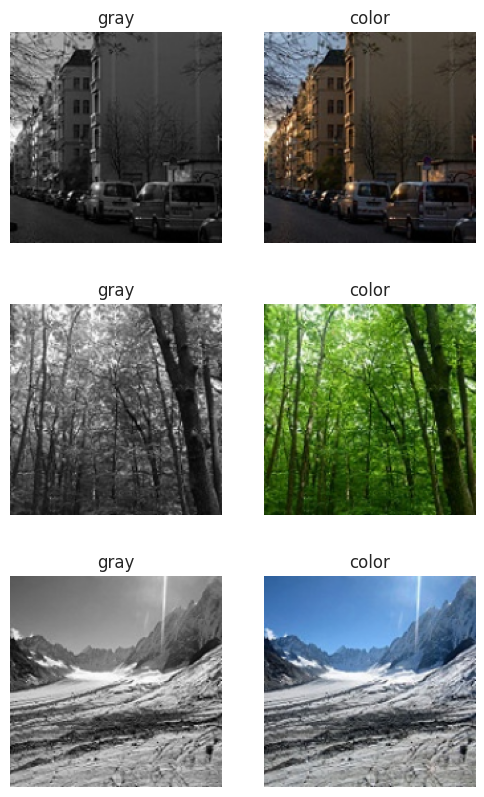

In [6]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 10))
for i in range(0,6,2):
  ax = plt.subplot(3, 2, i + 1)
  plt.imshow(cv2.cvtColor(gray[i].astype('uint8'), cv2.COLOR_BGR2RGB))
  plt.title("gray")
  plt.axis("off")
  ax = plt.subplot(3, 2, i + 2)
  plt.imshow(color[i].astype('uint8'))
  plt.title("color")
  plt.axis("off")

In [6]:
color /= 255
gray /= 255

In [7]:
def Colorizer(input_shape):
  encoder_input = keras.Input(shape=input_shape)
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1)(encoder_input)
  x = layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=2)(x)
  x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.Conv2D(128, (3, 3), activation='relu', padding='same', strides=2)(x)
  x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.Conv2D(256, (5, 5), activation='relu', padding='same', strides=1)(x)
  x = layers.Conv2D(256, (3, 3), activation='relu', padding='same', strides=2)(x)

  encoder_output =  layers.Conv2D(64, (3, 3), activation='relu', padding='same', strides=1)(x)

  x = layers.UpSampling2D((2, 2))(encoder_output)
  x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.UpSampling2D((2, 2))(encoder_output)
  x = layers.Conv2D(32, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.UpSampling2D((2, 2))(x)
  x = layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=1)(x)
  x = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same', strides=1)(x)
  decoder_output = layers.UpSampling2D((2, 2))(x)
  return keras.Model(encoder_input, decoder_output, name="decoder")

colorizer = Colorizer((160,160,1))

In [8]:
colorizer.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 160, 160, 64)      640       
                                                                 
 conv2d_1 (Conv2D)           (None, 80, 80, 64)        36928     
                                                                 
 conv2d_2 (Conv2D)           (None, 80, 80, 128)       73856     
                                                                 
 conv2d_3 (Conv2D)           (None, 40, 40, 128)       147584    
                                                                 
 conv2d_4 (Conv2D)           (None, 40, 40, 256)       295168    
                                                                 
 conv2d_5 (Conv2D)           (None, 40, 40, 256)       1638

In [9]:
def loss(y_true,y_pred) :
    l = tf.sqrt(tf.reduce_mean(tf.square(tf.abs(y_true - y_pred))))
    return l


In [10]:
colorizer.compile(loss=loss, optimizer='adam', metrics=['accuracy','mae','mse'])

In [11]:
X_train, X_test, y_train, y_test = train_test_split(gray, color, test_size=0.2, random_state=42)

In [12]:
tf.keras.backend.clear_session()
color = None
gray = None
import gc
gc.collect()

794

In [ ]:
batch_size = 500

# Calculez le nombre d'itérations nécessaires pour parcourir l'ensemble d'entraînement
num_batches = len(X_train) // batch_size
epochs = 10
# Entraînez votre modèle par lots
for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        # Sélectionnez le lot actuel
        X_batch = X_train[start_idx:end_idx]
        y_batch = y_train[start_idx:end_idx]

        # Entraînez le modèle avec le lot actuel
        hist = colorizer.fit(X_batch, y_batch,batch_size=32,epochs=10,validation_data = (X_test,y_test))

# Évaluez le modèle sur l'ensemble de validation à la fin de chaque époque
val_loss = colorizer.evaluate(X_test, y_test)


Epoch 1/10
16/16 [==============================] - 33s 1s/step - loss: 0.2657 - accuracy: 0.2571 - mae: 0.2248 - mse: 0.0717 - val_loss: 0.2451 - val_accuracy: 0.2785 - val_mae: 0.2090 - val_mse: 0.0601
Epoch 2/10
16/16 [==============================] - 5s 291ms/step - loss: 0.1917 - accuracy: 0.3550 - mae: 0.1519 - mse: 0.0375 - val_loss: 0.1634 - val_accuracy: 0.4077 - val_mae: 0.1231 - val_mse: 0.0268
Epoch 3/10
16/16 [==============================] - 5s 343ms/step - loss: 0.1579 - accuracy: 0.3885 - mae: 0.1188 - mse: 0.0250 - val_loss: 0.1522 - val_accuracy: 0.4091 - val_mae: 0.1127 - val_mse: 0.0233
Epoch 4/10
16/16 [==============================] - 5s 303ms/step - loss: 0.1459 - accuracy: 0.3851 - mae: 0.1081 - mse: 0.0213 - val_loss: 0.1407 - val_accuracy: 0.4297 - val_mae: 0.1028 - val_mse: 0.0199
Epoch 5/10
16/16 [==============================] - 5s 298ms/step - loss: 0.1400 - accuracy: 0.4110 - mae: 0.1034 - mse: 0.0196 - val_loss: 0.1362 - val_accuracy: 0.4094 - val_ma

In [ ]:
hist = colorizer.fit(X_train, y_train,batch_size=32,epochs=600,validation_data = (X_test,y_test))

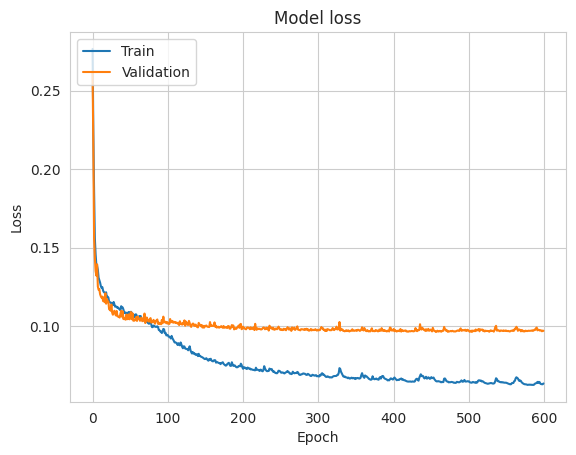

In [ ]:
import matplotlib.pyplot as plt
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

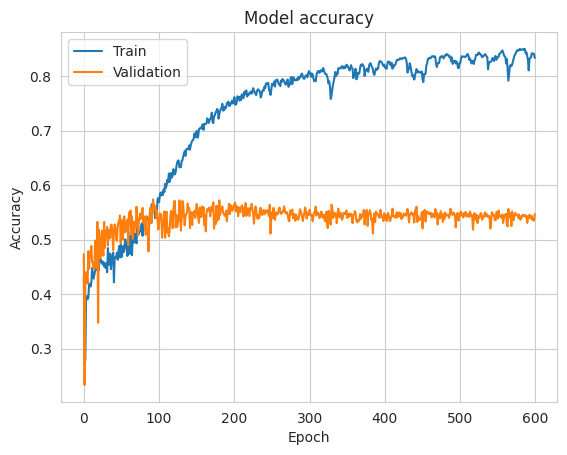

In [ ]:
# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
colorized_deneme = colorizer.predict(gray[20:30])

1/1 [==============================] - 0s 140ms/step


In [ ]:
gray[0:10].shape

(10, 160, 160, 1)

IndexError: ignored

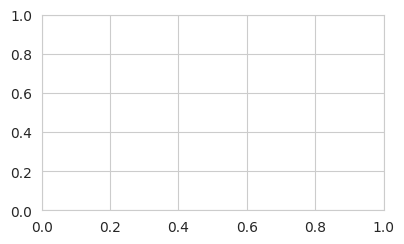

In [ ]:
plt.figure(figsize=(15,30))
for i in range(6,30,3):
  ax = plt.subplot(10, 3, i + 1)
  plt.imshow(cv2.cvtColor(gray[6000+i].astype("float32"), cv2.COLOR_BGR2RGB))
  plt.title("gray")
  plt.axis('off')
  ax = plt.subplot(10, 3, i + 2)
  plt.imshow(colorized_deneme[i])
  plt.title("colorized")
  plt.axis('off')
  ax = plt.subplot(10, 3, i + 3)
  plt.imshow(color[6000+i])
  plt.title("color")
  plt.axis('off')

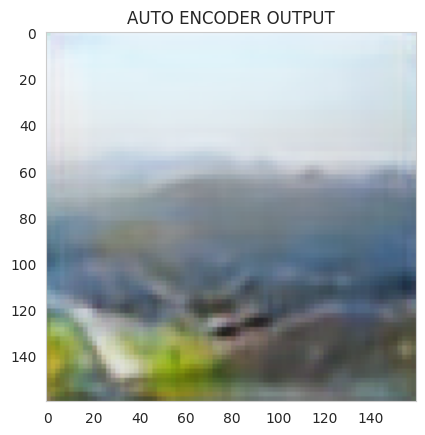

In [ ]:
# plt.figure(figsize=(5,5))
plt.imshow(colorized_deneme[0])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)

In [ ]:
plt.imshow(colorized_deneme[320])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)

IndexError: ignored

In [ ]:
plt.imshow(colorized_deneme[448])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)

IndexError: ignored

In [ ]:
plt.imshow(colorized_deneme[302])
plt.title("AUTO ENCODER OUTPUT")
plt.grid(False)

IndexError: ignored

###save model

In [ ]:
! pip install pyyaml h5py

In [ ]:
colorizer.save("/content/drive/MyDrive/Project /Colorisation Automatique d'Images avec AutoEncodeurs/models/autoencoder")

In [ ]:
colorizer.save("/content/drive/MyDrive/Project /Colorisation Automatique d'Images avec AutoEncodeurs/models/autoencoder.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from keras.models import load_model

# Charger le modèle depuis le fichier
model = load_model("/content/drive/MyDrive/Project /Colorisation Automatique d'Images avec AutoEncodeurs/models/autoencoder")